In [1]:
use_gdrive = False # @param {type:"boolean"}

RESULTS_PATH = "results2"

if use_gdrive:
  try:
    # mount your google drive to get permanent storage for your results
    from google.colab import drive
    drive.mount('/content/drive')

    RESULTS_PATH = "/content/drive/MyDrive/infoseclab25/results2"
  except ModuleNotFoundError:
    print("failed to mount gdrive")
else:
  print(f"saving results to '{RESULTS_PATH}'. If you're using Google Colab, this folder will be deleted when you disconnect!")

!mkdir -p {RESULTS_PATH}

saving results to 'results2'. If you're using Google Colab, this folder will be deleted when you disconnect!


In [2]:
import sys

# Lab files
![ ! -d 'infoseclab_25' ] && git clone https://github.com/ethz-spylab/infoseclab_25.git
%cd infoseclab_25
!git pull https://github.com/ethz-spylab/infoseclab_25.git
%cd ..
if "infoseclab_25" not in sys.path:
  sys.path.append("infoseclab_25")

Cloning into 'infoseclab_25'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 56 (delta 6), reused 0 (delta 0), pack-reused 37 (from 1)
Receiving objects: 100% (56/56), 320.02 MiB | 17.41 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (29/29), done.
/content/infoseclab_25
From https://github.com/ethz-spylab/infoseclab_25
 * branch            HEAD       -> FETCH_HEAD
Already up to date.
/content


# Imports

In [3]:
import infoseclab
from infoseclab import ShadowModels, utils, evaluation
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import scipy
import sklearn
import warnings
from zipfile import ZipFile


# Membership Inference

In this part of the lab, you will create a membership inference attack, with a twist: you do not know which shadow models were trained on which samples. We trained 127 shadow models on various subsets of a 50k sample 10-class dataset. Then we evaluated every shadow model on every sample and recorded their pre-softmax activations - you will find the corresponding dataframe below under the name `activations_fit`. Furthermore, we evaluated our to-be-attacked model on the whole dataset and recorded the pre-softmax activations again - you will find the corresponding dataframe below under the name `activations_attack`.

You are also provided with `partial_membership` information to help calibrate
your attacks. If an entry is 1/0 (member/non-member), the membership information for the corresponding sample has been provided to you as "ground-truth" information. If an entry is -1, it is your job to guess whether
the corresponding sample was used to train the target model.

First, load the data.

In [4]:
# Load data
activations_fit = ShadowModels.activations_fit           # pre-softmax activations from shadow models to construct your attack (50000 x 127 x 10)
activations_attack = ShadowModels.activations_attack     # pre-softmax activations from the target model to attack (50000 x 10)
labels = ShadowModels.labels                             # the class labels of all samples (50000 x 1)
partial_membership = ShadowModels.membership_dataframe   # partial membership vector; 1/0/-1 (member/non-member/unknown) for samples (50000)

num_samples, num_models, num_classes = activations_fit.shape
assert activations_attack.shape == (num_samples, num_classes)
assert labels.shape == (num_samples,)


**Implement your membership inference attack in the following cell.** Your attack should return a numpy array of size (50000,) with scores indicating whether the corresponding sample was used for training of the target model. The higher the score the more likely the sample was used for training.

In [5]:
import numpy as np
from scipy.special import logsumexp

labels_broadcast = np.repeat(labels[:, None], num_models, axis=1)

# phi logit
phifit = (activations_fit[np.arange(num_samples)[:, None], np.arange(num_models)[None, :],labels_broadcast] - logsumexp(activations_fit, axis=2))

phiattack = (activations_attack[np.arange(num_samples), labels] - logsumexp(activations_attack, axis=1))

# Lira Stil ratio berechnung nutze, number von samples
K = 8
eps = 2e-6
attack_scores = np.zeros(num_samples, dtype=np.float32)

for i in range(num_samples):
    s_sorted = np.sort(phifit[i])
    in_scores, out_scores = s_sorted[-K:], s_sorted[:K]

    muin, sigmain = in_scores.mean(), in_scores.std() + eps
    muout, sigmaout = out_scores.mean(), out_scores.std() + eps

    si = phiattack[i]
    logpin = -0.5 * ((si - muin) / sigmain) ** 2 - np.log(sigmain)
    logpout = -0.5 * ((si - muout) / sigmaout) ** 2 - np.log(sigmaout)

    attack_scores[i] = logpin - logpout


Once you developed an attack and would like to see how it is doing, you can execute the code below - it will plot a TPR vs. FPR curve for your attack on the validation split. If you want to evaluate multiple attacks you can call `plot_validation_roc` multiple times, just remember to pass fig and ax to the subsequent calls and make sure to set `plot_decorations = False` for all but the first call.

**Note:** To plot this curve we use a validation split of the dataset for which we know correct labels (member/non-member). You are free to use this validation split in any way you want (you can access it via `ShadowModels.get_validation_split`) but remember that once you incorporate this data into training it becomes useless as evaluation data. Furhtermore, in the realworld MIA setup it would be very unlikely to have access to ground truth. This exercise is perfectly solvable without using this data. Lastly, you will be evaluted on the test split which is disjoint w.r.t. validation set.

validation set TPR @ FPR 1.00%: 7.32%


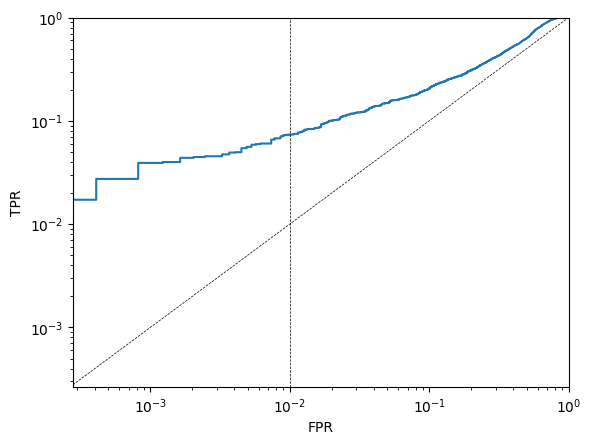

In [6]:
fig, ax = ShadowModels.plot_validation_roc(
    attack_scores,
    fig=None,
    ax=None,
    label="validation set",
    plot_decorations=True,
)

Once you are satisfied with your scores run the cell below to run sanity checks on the scores and save the results

In [7]:
# Run sanity checks on the scores
ShadowModels.assert_valid_scores(attack_scores)

# Save scores
utils.save_attack_scores(os.path.join(RESULTS_PATH, "attack_scores.npy"), attack_scores)

# Create submission file (**upload `results2.zip` to moodle**)

In [8]:
!zip -j -FSr "{RESULTS_PATH}/results2.zip" {RESULTS_PATH}

  adding: attack_scores.npy (deflated 6%)


In [9]:
from infoseclab.submission import validate_zip2
assert validate_zip2(f"{RESULTS_PATH}/results2.zip")

Zip file is valid
